# Sentiment analysis with a transformer encoder.

This notebook contains code that demonstrates how to build a transformer encoder from scratch for binary sentiment classification.

In [383]:
import pandas as pd
# Set the device to GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# DATA
DATA = pd.read_csv('data/go_emotions_dataset.csv')
CATEGORIES = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

TEXT = 'text'
TOTAL_SIZE = len(DATA)
# CONFIGURATION
TRAIN_SIZE = int(TOTAL_SIZE*0.8)
VAL_SIZE = int(TOTAL_SIZE*0.1)
TEST_SIZE = int(TOTAL_SIZE*0.1)

TRAIN_DATA = DATA[:TRAIN_SIZE]
TRAIN_DATA = TRAIN_DATA[TRAIN_DATA['example_very_unclear'] == False]

VAL_DATA = DATA[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

TEST_DATA = DATA[TRAIN_SIZE+VAL_SIZE:]

print(f"Train size: {len(TRAIN_DATA)}")
print(f"Val size: {len(VAL_DATA)}")
print(f"Test size: {len(TEST_DATA)}")

# MODEL PARAMS
BATCH_SIZE=32
VOCAB_SIZE=10000
SEQUENCE_LENGTH=128
EMBEDDING_DIM=100
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=3
NUM_EPOCHS=40

Train size: 56041
Val size: 7122
Test size: 7123


## 1. Data loading.

In [384]:
def load_and_split_data(data):
    text = data[TEXT].values
    label = data[CATEGORIES].values
    return text, label

# Load the data
train_data, train_labels = load_and_split_data(TRAIN_DATA)
val_data, val_labels = load_and_split_data(VAL_DATA)
test_data, test_labels = load_and_split_data(TEST_DATA)


train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))



## 2. Data preprocessing.

In [385]:

def standardization(input_data):
    input_data = tf.strings.lower(input_data)
    input_data = tf.strings.regex_replace(input_data, r'\d+', '')
    input_data = tf.strings.regex_replace(input_data, r'[^\w\s]', '')
    input_data = tf.strings.strip(input_data)
    return input_data






In [386]:
vectorize_layer=tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=SEQUENCE_LENGTH
)


In [387]:
training_dataset = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(training_dataset)


In [388]:
def vectorizer(review,label):
    review =  vectorize_layer(review)
    if len(review)<SEQUENCE_LENGTH:
        review = tf.pad(review, [[0,SEQUENCE_LENGTH-len(review)]])
    return review,label

In [389]:
import pickle
with open('models/vectorize_layer_weights.h5', 'wb') as f:
    pickle.dump(vectorize_layer.get_weights(), f)

In [390]:
train_dataset=train_dataset.map(vectorizer)
val_dataset=val_dataset.map(vectorizer)
test_dataset=test_dataset.map(vectorizer)



In [391]:
train_dataset=train_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

## 3. Data modelling
### 3.1. Embedding layer.

In [392]:
import numpy as np
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [393]:
class Embeddings(tf.keras.layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=tf.keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config

### 3.2 Encoder layer.

In [394]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

### 3. Final model.

In [395]:
encoder_input=tf.keras.layers.Input(shape=(None,), dtype="int64", name="input")

x = Embeddings(SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_input)

for _ in range(NUM_LAYERS):
  
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)

x = tf.keras.layers.Flatten()(x)
output=tf.keras.layers.Dense(28, activation="softmax")(x)

transformer = tf.keras.Model(
    encoder_input, output, name="transformer"
)
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embeddings_23 (Embeddings)   (None, 128, 100)          1000000   
_________________________________________________________________
transformer_encoder_35 (Tran (None, 128, 100)          528824    
_________________________________________________________________
transformer_encoder_36 (Tran (None, 128, 100)          528824    
_________________________________________________________________
transformer_encoder_37 (Tran (None, 128, 100)          528824    
_________________________________________________________________
flatten_23 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_99 (Dense)             (None, 28)                

In [396]:
checkpoint_filepath = 'models/transformer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [399]:

transformer.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              metrics=['accuracy'])



### 4. Model training.

In [400]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, reduce_lr])

Epoch 1/40
1751/1751 [==============================] - 210s 93ms/step - loss: 3.5829 - accuracy: 0.2647 - val_loss: 3.5230 - val_accuracy: 0.2615
Epoch 2/40
1751/1751 [==============================] - 122s 69ms/step - loss: 3.5707 - accuracy: 0.2654 - val_loss: 3.5151 - val_accuracy: 0.2615
Epoch 3/40
 260/1751 [===>..........................] - ETA: 1:35 - loss: 3.5996 - accuracy: 0.2662 ETA: 1:38 - loss: 3.5918  - ETA: 1:38 - loss: - ETA: 1:37 - los - ETA: 1:36 - loss: 3.6008 -  - ETA: 1:36 - loss: 3.5985 - accuracy: 

KeyboardInterrupt: 

### 5. Accuracy evolution.

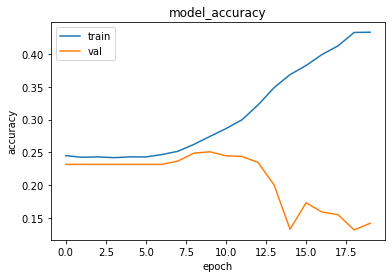

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Jaccard Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()